# David Hadaller

In [1]:
import pandas as pd
from pandas import Timestamp

import matplotlib.dates
import matplotlib.pyplot as plt

import numpy as np
import datetime
import math
import sys

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
#this is a dataset for the timestamps of busses at the Amsterdam & 125th st stop on M100 line going uptown 
busDepartures = pd.read_csv("../../data/Arrivals_M100.csv",index_col=0)

# loopTime is the minimum amount of time, in minutes, that it takes a bus to complete the bus route and 
    # arrive at this stop to complete the circuit once again
loopTime = datetime.timedelta(minutes=105)

# Ensure ordering by VehicleRef (a vehicle identifier for busses) and RecordedAtTime (timestamps)
busDepartures = busDepartures.sort_values(['VehicleRef','RecordedAtTime'])

# Resetting Index and deleting resulting index column after ordering for shift later on.
busDepartures = busDepartures.reset_index()
busDepartures.drop(columns=['index',],inplace=True)

# Ensure that RecordedAtTime is of correct data type to find timedelta
busDepartures['RecordedAtTime'] = pd.to_datetime(busDepartures['RecordedAtTime'])

# find difference between CURRENT timestamp and PREVIOUS for each gps-timestamp
    #busDepartures['timeDelta'] = busDepartures_Grouped['RecordedAtTime'].diff()
busDepartures['timeDelta'] = busDepartures['RecordedAtTime'].diff()

# we want to find all the timestamps where busses pull away from this one stop. 
    # the departure time is when we consider that a passenger is no longer waiting for their journey to start. 
    # hence, we count bus idleing as part of the passengers experienced wait time

# wherever the difference between two consecutive timestamps is greater than the loopTime, 
    # the bus has finished it's route and come back to the same stop it started at.
    # The bus is not idleing.  
busDepartures['hasLooped'] = busDepartures['timeDelta'] > loopTime

#fixing some edge cases e.g. the first datapoint has no timedeta because no other time precedes it
busDepartures.loc[0,'timeDelta'] = 0

# # where the timedeta is NaT, set to haslooped=True. We do this so that the first Entry for a given Vehicleref won't 
#     # count as a departure time, but the last entry from the previous VehicleRef entry will.
# busDepartures.loc[busDepartures['timeDelta'].isnull(),'hasLooped'] = True

# wherever the next arrival is a Looparound, the current timestamp is considered a departure from the stop
busDepartures['isDeparting'] = busDepartures['hasLooped'].shift(-1)

#the last entry in the entire dataframe must be included as a departure
busDepartures.loc[busDepartures.index[-1], 'isDeparting']= True

# If the next bus is not the same as the current bus, then this entry must be considered a departure
busDepartures['NextVehicleRef'] = busDepartures['VehicleRef'].shift(-1).fillna("") #create next bus column by shifting current bus up by 1 relative to index
mask = busDepartures['VehicleRef'] != busDepartures['NextVehicleRef']
busDepartures.loc[mask, 'isDeparting'] = True

# return all rows where the busses are departing
busDepartures = busDepartures[busDepartures['isDeparting'] != False]

Now we need to recalculate the `timeDelta`s (the time since the last bus departed from the stop). Before we wanted values like 12 hours, because busses before a time delta like that are certainly departing, not idleing (they're the last bus for 12 hours). This time, we ordering by date. TO do that we must separate the date from the timestamps in the  `RecordedAtTime` column.

In [4]:
#busDepartures = busDepartures.loc[:,['RecordedAtTime','VehicleRef']]

# need to change the datetime to string to apply string split methods
busDepartures['RecordedAtTime'] = busDepartures['RecordedAtTime'].dt.strftime('%Y-%m-%d %H:%M:%S')

#apply split to retrieve date without time
splitCol = busDepartures['RecordedAtTime'].str.split(' ', 1, expand=True).rename(columns={0:'Date', 1:'Time'}) 
busDepartures['Date'] = splitCol['Date'] 

#apply split to retrieve time without date 
busDepartures['Time'] = splitCol['Time']
busDepartures['Time'] = pd.to_datetime(busDepartures['Time'],format='%H:%M:%S')

busDepartures = busDepartures.sort_values(['RecordedAtTime'])

#at the start of each new day, set the time delta to 0. (we assume no passenger is waiting through night for next bus)
busDepartures['TimeDelta'] = busDepartures['Time'].diff()
busDepartures['PrevDate'] = busDepartures['Date'].shift(1)
mask = busDepartures['PrevDate'] != busDepartures['Date']
busDepartures.loc[mask,'TimeDelta'] = pd.Timedelta(0, unit='m')

# drop columns no longer needed
busDepartures.drop(['Time','PrevDate'],axis=1,inplace=True)

In [5]:
# busDepartures.columns
# busDepartures.shape
# busDepartures.dtypes

Before we begin the simulation, we need to establish what will become the arguments to `numpy.random.uniform(low=0.0, high=1.0, size=None)`. Below, we find the `low` and `high` parameters. That is, we find the first and last bus arrival times for each day.

In [6]:
DailyBusMinMax= busDepartures.loc[:,['RecordedAtTime','Date']]

DailyBusMinMax = DailyBusMinMax.drop_duplicates()

DailyBusMax = DailyBusMinMax.groupby('Date').max()
DailyBusMin = DailyBusMinMax.groupby('Date').min()

DailyBusMinMax = pd.merge(left=DailyBusMin, right=DailyBusMax, how='inner',on='Date', suffixes=('Min', 'Max'))
DailyBusMinMax = DailyBusMinMax.rename(columns={'RecordedAtTimeMin':'EarliestBusDeparture', 'RecordedAtTimeMax':'LatestBusDeparture'})

DailyBusMinMax.reset_index(level=0, inplace=True)
DailyBusMinMax['Date'] = pd.to_datetime(DailyBusMinMax['Date'],format='%Y-%m-%d')
DailyBusMinMax['EarliestBusDeparture'] = pd.to_datetime(DailyBusMinMax['EarliestBusDeparture'], format='%Y-%m-%d %H:%M:%S')
DailyBusMinMax['LatestBusDeparture'] = pd.to_datetime(DailyBusMinMax['LatestBusDeparture'], format='%Y-%m-%d %H:%M:%S')

DailyBusMinMax.head(30)

,Date,EarliestBusDeparture,LatestBusDeparture
0,2017-08-01,2017-08-01 00:11:39,2017-08-01 23:13:22
1,2017-08-02,2017-08-02 00:22:34,2017-08-02 22:55:06
2,2017-08-03,2017-08-03 00:35:38,2017-08-03 23:27:49
3,2017-08-04,2017-08-04 00:37:30,2017-08-04 23:39:27
4,2017-08-05,2017-08-05 00:39:12,2017-08-05 23:31:11
5,2017-08-06,2017-08-06 00:41:24,2017-08-06 23:52:56
6,2017-08-07,2017-08-07 00:32:30,2017-08-07 23:04:06
7,2017-08-08,2017-08-08 00:04:29,2017-08-08 23:56:22
8,2017-08-09,2017-08-09 00:05:59,2017-08-09 23:47:54
9,2017-08-10,2017-08-10 00:28:04,2017-08-10 23:19:19


In the cell below, we take the bus departure times (when the bus pulls out of the stop), the dates associated with each bus departure time (to help with subsequent merges) and the timedeltas (which we may plot later on) from the `busDepartures`, which we got from the original `Arrivals_M100` data

In [7]:
busDepartureTimes = busDepartures.loc[:,['RecordedAtTime','VehicleRef','TimeDelta','Date']]
busDepartureTimes = busDepartureTimes.rename(columns={'RecordedAtTime':'BusDepartureTime'})

# Change Column DataTypes from String (object) to DateTime
busDepartureTimes['BusDepartureTime'] = pd.to_datetime(busDepartureTimes['BusDepartureTime'], format='%Y-%m-%d %H:%M:%S')
busDepartureTimes['Date'] = pd.to_datetime(busDepartureTimes['Date'], format='%Y-%m-%d %H:%M:%S')
busDepartureTimes = busDepartureTimes.drop_duplicates()

busDepartureTimes.head()

,BusDepartureTime,VehicleRef,TimeDelta,Date
1089,2017-08-01 00:11:39,NYCT_4349,00:00:00,2017-08-01
1906,2017-08-01 00:21:06,NYCT_4368,00:09:27,2017-08-01
4323,2017-08-01 01:01:11,NYCT_8375,00:40:05,2017-08-01
1045,2017-08-01 06:11:35,NYCT_4348,05:10:24,2017-08-01
1755,2017-08-01 06:41:31,NYCT_4363,00:29:56,2017-08-01


Next, we define a simulation function which gets the `low` and `high` bounds of the uniform distribution from the DailyBusMinMax dataframe and then takes `NumPassengers` for population size of passengers to simulate. 

This simulation function creates a "pivot table" with the Date as pseudo-index and an artificial passengerId for column headers. For each date, the table contains each passenger in NumPassengers simulated bus arrival time (the time at which each passenger approaches the bus stop with the hopes of boarding a bus.)

Of course, the table that results isn't a true pivot table, because the Date column is just another column, rather than a pandas index. Keeping the Date as a column allows us to reference it as a column later on, which will come in handy when we need to return a series of dates.

In [8]:
def passengerSim(DailyBusMinMax, NumPassengers):
    
    #time between the first and last bus arrivals
    dailyDelta = DailyBusMinMax['LatestBusDeparture'] - DailyBusMinMax['EarliestBusDeparture']
    
    # the first bus arrival
    dailyMin = DailyBusMinMax['EarliestBusDeparture']
    
    #number of dates to simulate for
    NumDates = len(DailyBusMinMax.Date)
    
    #this vectorized calculation follows the formula dailyDelta * randomVar + firstBusArrival to choose a random time
        # between the EarliestBusDeparture and the LatestBusDeparture.
        # this is done for every date and for each passenger in NumPassengers
    pSim = pd.DataFrame(np.random.uniform(0,1,(NumDates,NumPassengers)))
    pSim = pSim.mul(dailyDelta,axis=0)
    pSim = pSim.add(dailyMin,axis=0)
    
    # add a dates column to front of dataframe  
    pSim.insert(loc=0, column='Date', value=DailyBusMinMax['Date'])
    
    return pSim

In [9]:
sim = passengerSim(DailyBusMinMax,500)
sim.head()

,Date,0,1,2,3,4,5,6,7,8,...,490,491,492,493,494,495,496,497,498,499
0,2017-08-01,2017-08-01 05:35:32.346645852,2017-08-01 18:49:35.625061681,2017-08-01 18:28:15.167920006,2017-08-01 10:32:54.345581510,2017-08-01 08:04:00.979361902,2017-08-01 12:49:30.889782445,2017-08-01 15:57:47.828909715,2017-08-01 10:25:29.383494295,2017-08-01 17:47:44.292927051,...,2017-08-01 20:07:07.385000450,2017-08-01 15:00:56.159846994,2017-08-01 12:27:48.353691006,2017-08-01 22:17:32.825235669,2017-08-01 13:34:50.061821615,2017-08-01 18:33:16.474606090,2017-08-01 18:31:14.654253834,2017-08-01 04:33:22.899046901,2017-08-01 12:32:28.561152270,2017-08-01 22:06:06.784533941
1,2017-08-02,2017-08-02 02:37:33.085139198,2017-08-02 11:54:56.787778391,2017-08-02 02:22:34.790927655,2017-08-02 19:52:55.876892961,2017-08-02 00:26:24.888744151,2017-08-02 22:06:23.742183214,2017-08-02 21:17:49.966844187,2017-08-02 06:20:13.608633228,2017-08-02 16:15:48.598550447,...,2017-08-02 15:20:37.816866469,2017-08-02 11:19:57.872277449,2017-08-02 04:19:10.513600556,2017-08-02 07:09:23.776279337,2017-08-02 12:49:55.913548576,2017-08-02 12:29:42.656057524,2017-08-02 01:56:43.514098197,2017-08-02 18:19:59.514921020,2017-08-02 18:18:37.578777630,2017-08-02 01:33:03.815247448
2,2017-08-03,2017-08-03 06:50:18.678787082,2017-08-03 08:16:17.091488437,2017-08-03 17:24:28.376622852,2017-08-03 09:20:23.365149358,2017-08-03 17:54:34.794577888,2017-08-03 14:45:51.752129890,2017-08-03 11:44:57.195834311,2017-08-03 20:13:59.225004969,2017-08-03 16:27:55.032160775,...,2017-08-03 03:26:34.394129078,2017-08-03 04:26:37.179127597,2017-08-03 00:38:34.173015986,2017-08-03 07:30:17.411038083,2017-08-03 03:49:09.984115108,2017-08-03 02:41:06.719898273,2017-08-03 02:19:10.208340152,2017-08-03 20:21:39.337150235,2017-08-03 10:25:49.336358501,2017-08-03 15:25:36.904070390
3,2017-08-04,2017-08-04 19:41:02.872055657,2017-08-04 19:37:05.311141119,2017-08-04 23:10:00.831337803,2017-08-04 02:26:43.861238406,2017-08-04 04:11:19.864120512,2017-08-04 02:45:11.541175760,2017-08-04 14:11:08.357204690,2017-08-04 05:28:19.520450569,2017-08-04 04:00:21.369381319,...,2017-08-04 20:48:43.390848664,2017-08-04 20:21:26.995641494,2017-08-04 22:19:10.273939381,2017-08-04 13:22:38.296900709,2017-08-04 13:31:38.796646346,2017-08-04 15:16:19.633614655,2017-08-04 06:40:21.906017547,2017-08-04 19:26:28.518635169,2017-08-04 16:07:55.051642787,2017-08-04 10:18:22.290882601
4,2017-08-05,2017-08-05 08:25:59.399892922,2017-08-05 19:01:59.419136314,2017-08-05 03:07:12.792381996,2017-08-05 10:57:40.490927150,2017-08-05 05:08:57.031283883,2017-08-05 15:49:31.638094130,2017-08-05 23:28:16.263871754,2017-08-05 06:53:54.702161097,2017-08-05 01:20:20.837433519,...,2017-08-05 17:33:30.772606201,2017-08-05 09:54:16.482838612,2017-08-05 20:08:42.526313399,2017-08-05 04:19:15.507680414,2017-08-05 02:38:44.765445013,2017-08-05 12:25:37.370551410,2017-08-05 20:29:04.821441694,2017-08-05 02:24:07.707945237,2017-08-05 15:20:17.934764168,2017-08-05 08:19:56.593623909


Here, we reorganize the results of the passenger simulation to get a table that has one single `passengerId` column, instead of one column for each passenger. This is will allow us to perform a merge in the following step.

In [10]:
sim = sim.melt(id_vars='Date')
sim = sim.rename(columns={'variable':'passengerId','value':'passengerArrivalTime'})
sim.head()

,Date,passengerId,passengerArrivalTime
0,2017-08-01,0,2017-08-01 05:35:32.346645852
1,2017-08-02,0,2017-08-02 02:37:33.085139198
2,2017-08-03,0,2017-08-03 06:50:18.678787082
3,2017-08-04,0,2017-08-04 19:41:02.872055657
4,2017-08-05,0,2017-08-05 08:25:59.399892922


As promised, we now merge the passenger simulation,`sim` with the bus departure times, `busDepartureTimes`. The result of the code below is a lookup table where each passenger arrival time is associated with one bus arrival time; that is to say, the passengers are associated with the bus they board (which will always be the next bus that departs from the stop after they arrive.)

In [11]:
# The powerset of all passenger-bus combinations
busBoarding = pd.merge(right=sim, left=busDepartureTimes, on='Date', how='inner')

#  busses already departed from stop cannot be boarded by passengers who arrive at the stop later on.
    # (no going back in time)
busBoarding = busBoarding.loc[busBoarding['BusDepartureTime']>=busBoarding['passengerArrivalTime']]

# the passenger is reasonable and will board the first bus that departs from the stop after they arrive
busBoarding = busBoarding.groupby(['Date','passengerId','passengerArrivalTime']).first()

# we reset the index to group by a different column in the next step
busBoarding = busBoarding.reset_index().sort_values(['Date','BusDepartureTime','passengerId'])
busBoarding.head()


,Date,passengerId,passengerArrivalTime,BusDepartureTime,VehicleRef,TimeDelta
96,2017-08-01,96,2017-08-01 00:13:23.260947127,2017-08-01 00:21:06,NYCT_4368,00:09:27
181,2017-08-01,181,2017-08-01 00:14:22.507842002,2017-08-01 00:21:06,NYCT_4368,00:09:27
205,2017-08-01,205,2017-08-01 00:16:28.710084169,2017-08-01 00:21:06,NYCT_4368,00:09:27
470,2017-08-01,470,2017-08-01 00:17:55.816108742,2017-08-01 00:21:06,NYCT_4368,00:09:27
52,2017-08-01,52,2017-08-01 00:49:08.060857136,2017-08-01 01:01:11,NYCT_8375,00:40:05


Now, we calcuate the number of people per bus by grouping by `BusArrivalTime` and then counting the number of entries in each group. We then merge this `busCrowding` DataFrame back into our `busBoarding` DataFrame from the previous step to give us a `numPassengersPerBus` column, which tells us exactly how many of our simulated passengers boarded each bus.

In [12]:
busCrowding = busBoarding.groupby(['BusDepartureTime']).count()
busCrowding = pd.DataFrame(busCrowding['passengerId']).rename(columns={'passengerId':'numPassengersPerBus'})
busCrowding = busCrowding.reset_index()

busBoarding = pd.merge(left=busBoarding, right=busCrowding, on='BusDepartureTime', how='inner')
busBoarding.head()
busBoarding.shape

,Date,passengerId,passengerArrivalTime,BusDepartureTime,VehicleRef,TimeDelta,numPassengersPerBus
0,2017-08-01,96,2017-08-01 00:13:23.260947127,2017-08-01 00:21:06,NYCT_4368,00:09:27,4
1,2017-08-01,181,2017-08-01 00:14:22.507842002,2017-08-01 00:21:06,NYCT_4368,00:09:27,4
2,2017-08-01,205,2017-08-01 00:16:28.710084169,2017-08-01 00:21:06,NYCT_4368,00:09:27,4
3,2017-08-01,470,2017-08-01 00:17:55.816108742,2017-08-01 00:21:06,NYCT_4368,00:09:27,4
4,2017-08-01,52,2017-08-01 00:49:08.060857136,2017-08-01 01:01:11,NYCT_8375,00:40:05,15


(14500, 7)

We now take a few columns of the `busBoarding`data that to plot the relationship between `passengerArrivalTime` and `numPassengersPerBus`.

In [13]:
plotData = busBoarding.loc[:,['passengerArrivalTime','numPassengersPerBus']]
plotData['passengerArrivalTime'] = plotData.passengerArrivalTime.dt.time
plotData.head()
plotData.shape

,passengerArrivalTime,numPassengersPerBus
0,00:13:23.260947,4
1,00:14:22.507842,4
2,00:16:28.710084,4
3,00:17:55.816108,4
4,00:49:08.060857,15


(14500, 2)

Finally, we have our plot.

(array([-10000.,      0.,  10000.,  20000.,  30000.,  40000.,  50000.,
         60000.,  70000.,  80000.,  90000.]),
 <a list of 11 Text xticklabel objects>)

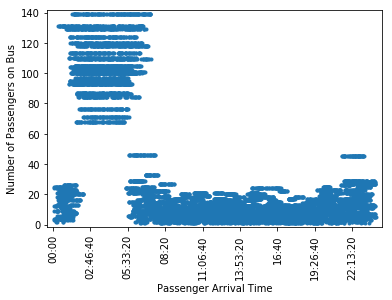

In [14]:
plotData = plotData.sort_values('passengerArrivalTime', ascending=True)
_= plt.plot(plotData['passengerArrivalTime'], plotData['numPassengersPerBus'],'.',linestyle='none')
_ = plt.xlabel('Passenger Arrival Time')
_ = plt.ylabel('Number of Passengers on Bus')
_ = plt.margins(0.02) # Keeps data off plot edges
plt.xticks(rotation='vertical')

Each horizontal line represents one busload of people. Notice that the above plot features a series of points a the 140 people mark. This could signify that the uniform distribution hypothesis may have been too generous, since, during the hours between 3am and 5am, most people are asleep. And few busses run druring those times, so assuming people will wait for hours until the next bus comes might be an unnatural assumption to make. FOr this reason, we can restrict our analysis to the times between 5am and 1am the next day for our machine learning models.

In [ ]:
busBoarding.to_csv('../../data/busBoarding.csv')